In [1]:
# Constrained water and energy balance estimation 
# v4.2: adapted from v4.1 by treating SCF known, G estimated offline
# v4.3: adapted from v4.2 & 3.3 to handle to batch processing on OSC
# v4.4: adapted from v4.3 to update ipopt deprecation
# v4.5: moving σWRFG based on SCF 7/2/20 JLD
# v4.6: adding SDC to objective function: MD & JD: 9/28/20
# v4.7: adding "pseudo-valid prior" to starting points. remove SDC. MD: 1/7/21
# v4.8: tweak error parameters. MD & JD: 1/8/21
# v4.9 prior valid added to objective function. daily G capped in constraints. more outputs written 10/5/21
# v4.9.1 remove SWE from objective
# v4.9.2 added air temp
# v51 Converted to function but still uses textfile as input
# v52 Prototyping to pass the array directly to function [and fixed tab to 4 spaces]
# v53 To set tab to 4 spaces (by copying/pasting)
# v54 combine 9 separate textfile output in one txt file (due to file count limitation on Discover)
# v55 Fixing error due to missing days of data due to Polar nights
# v58 New updates by jack (Nov 2023)
# Jan 29, 2024: Due to error on obj function σWRFG becoming zero, fixed the minimum σWRFG to 25 
# Jun 21, 2024: No change for 1km run here. MODIS with UINT8 did not work likely because of missing due to no-data background and polar nights.
# Oct 06, 2025: Updated main Blender function to handle new precip scaling algorithm.


using NCDatasets
using Random
using JuMP
using Ipopt
using DelimitedFiles
using Statistics
using Distributions
Random.seed!(1234)  # seed for reproducibility


TaskLocalRNG()

In [2]:
function blender(i, j, SWEprior, Pprior, Gprior, SCFinst, AirT, PSval, logDir, exp_dir, twindow=1)
  """
  changing twindow from 2 to 1 (May 19, 2025)
  inputs
  ==============
  i,j are pixel locations
  SWEprior, Pprior, Gprior are prior estimates of SWE [m], Precipitation [m] and surface heat flux [W/m2]
  SCFinst is measured snow covered fraction
  AirT is air temperature [K]
  logdir and exp_dir are directories where log and data are written
    
  variable sizes
  =============== 
  SWE and SCF are storage terms, so will be length nt. 
  P, Melt, and G are flux terms, so will be length nt-1
  for input, all variables are length nt, so just use Pprior[1:nt-1]. Note, Gprior currently unused
  for output in section 4, will output fluxes as nt, with the last element set to 0.    

  """
    # 0 handle variable sizes
    nt = length(SCFinst)
    Pprior = Pprior[1:nt-1]
    # println("Inside Estimate_v61...")
    # println(SCFinst)

    # TODO This is prototype only to Fill in missing SCF values
    #  Write a function that returns SCF based on LIS SWE prior.
    for i=1:nt
        if ismissing(SCFinst[i])
            if SWEprior[i] <= 0  # if SWE is zero, then SCF is zero
                SCFinst[i] = 0
            elseif SWEprior[i] > 0 && SWEprior[i] < 0.1
                SCFinst[i] = 0.1
            elseif SWEprior[i] >= 0.1 && SWEprior[i] < 0.5
                SCFinst[i] = 0.5
            elseif SWEprior[i] >= 0.5
                SCFinst[i] = 0.75
            end
        end
    end

    # 1 Smooth SCF observations
    # twindow = 5
    SCFobs = smoothdata(SCFinst, twindow, nt, "median")
    # SCFobs = fix_modis(SCFinst)  # apply MODIS fix developed by Jack (Feb 04, 2025)
    # twindow = 60
    SCF_smooth_season = smoothdata(SCFinst, 30, nt, "mean")  # before it was 60
    # Quick check to make sure scalar never nans out
    Pprior = PSval.*Pprior;
    SWEprior = PSval.*SWEprior;

    # 2 Define hyperparameters
    tmelt,tmelt_smooth,SWEmax,SWEmin_global,Meltmax,σP,σSWE,k,Melt0,L=define_hyperparameters(SCF_smooth_season, nt, Pprior, SWEprior, AirT, SCFobs)

    # 3 Solve
    m = Model(optimizer_with_attributes(Ipopt.Optimizer,"max_iter"=>5000))
    # set_silent(m)
    # define variables and bounds
    @variable(m, SWEmin_global <= SWE[i=1:nt] <= SWEmax[i], start=SWEprior[i])
    @variable(m, Precip[i=1:nt-1]>=0. ,start=Pprior[i]);
    @variable(m, 0. <= Melt[i=1:nt-1]<= Meltmax)
    @variable(m, Mcost[i=1:nt-1] >=0)
    # define constraints
    for i in 1:nt-1
      @NLconstraint(m,Mcost[i]==L/(1+exp( -k*(Melt[i]-Melt0))))
    end
    for i in 1:nt-1
      @constraint(m,SWE[i+1]==SWE[i]+Precip[i]-Melt[i])
    end
    # define objective function
    @objective(m,Min,sum((Precip-Pprior).^2 ./σP.^2) + sum((SWE-SWEprior ).^2 ./ σSWE.^2) + sum(Mcost.^2))
    log_file =  "$logDir/Pix_$(i)_$(j).txt"  # _$(twindow)
    # solve
    redirect_stdio(stdout=log_file, stderr=log_file) do
      optimize!(m)
    end
    # print(termination_status(m))
    
    # 4 extract
    NODATAvalue = -9999
    SWEhat=JuMP.value.(SWE)
    Phat=zeros(nt,1)
    Phat[1:nt-1] = JuMP.value.(Precip)
    Melt_hat = zeros(nt,1)
    Melt_hat[1:nt-1] = JuMP.value.(Melt);
    
    Δt = 86400; #s/day
    ρw = 1000; #density of water
    Lf = 0.334E6; #Latent heat of fusion J/kg    
    GmeltHat = Melt_hat/Δt*Lf*ρw
    
    Ghat = ones(nt,1)*NODATAvalue
    Ushat = ones(nt,1)*NODATAvalue
    G_pv = ones(nt,1)*NODATAvalue
    U_pv = ones(nt,1)*NODATAvalue
    Gmelt_pv = ones(nt,1)*NODATAvalue
    SWEpv = ones(nt,1)*NODATAvalue
    
    # 5 output
    out_vars = hcat(SWEhat, GmeltHat, Ghat, Phat, Ushat, G_pv, Gmelt_pv, U_pv, SWEpv, SCFobs)
    # writedlm("$(exp_dir)/Pix_$(i)_$(j)_$(twindow).txt", out_vars)
    writedlm("$(exp_dir)/Pix_$(i)_$(j).txt", out_vars)
    writedlm("$(exp_dir)/SWE.txt", SWEhat)
    writedlm("$(exp_dir)/Phat.txt", Phat)
    writedlm("$(exp_dir)/SCFhat.txt", SCFobs)
    # 6 clean up
    m = nothing
    GC.gc()
    return nothing    
end


function smoothdata(SCF_inst, twindow, nt, smoothfunc)
    """
    Smooth data using a moving average or median filter.
    Parameters:
    ============
    SCF_inst: Input data to be smoothed.
    twindow: Window size for smoothing.
        example: 1 means smooth using 1 data point on either side of the current point.
        In this formulation, use half the value that was originally used by Mike (ie, 60 is now 30 etc.).
    nt: Length of the input data.
    smoothfunc: Type of smoothing function ('mean' or 'median').

    """
    # println("Inside Smoothing data...")
    # println("$twindow, $nt, $smoothfunc")
    # better to copy "SCF_inst" so the smooth function doesn't modify the original data. Even better apppend border on both sides of the data.
    SCF_smooth=zeros(nt,1)
    for i=(1+twindow):(nt-twindow)
        # adding 1 (ie, 1+twindow) in the for loop because Julia is 1-based indexing
        if smoothfunc == "mean"
            SCF_smooth[i] = mean(SCF_inst[i-twindow:i+twindow])
            # SCF_smooth[i] = mean(skipmissing(SCF_inst[i-twindow:i+twindow]))  # use this when there is missing data
        elseif smoothfunc=="median"
            SCF_smooth[i] = mean(SCF_inst[i-twindow:i+twindow])
            # SCF_smooth[i] = mean(skipmissing(SCF_inst[i-twindow:i+twindow]))  # use this when there is missing data
        end
    end    
    return SCF_smooth
end

function define_uncertainty(Pprior, SWEprior, AirT, SCFobs, nt, tmelt_smooth)
    # convert air temperature K-> C
    AirT = AirT.-273.15
    
    # 2.2.1 Precipitation Uncertainty
    RelPUnc = 0.3; #[-] this applies to cumulative precipitation
    # Uncertainty for accumulation . precip is size nt-1
    σP = zeros(nt-1,1)
    σPmin = 0.001
    Pthresh = 0.001
    for i=1:nt-1
      if Pprior[i]<Pthresh
        σP[i]=σPmin
      else
        σP[i]=Pprior[i]*RelPUnc
      end
    end    
    # adjust uncertainty to apply to the number of snow days
    nsnowday = 0
    Tprecip_thresh = 1.5
    for i=1:nt-1
        if Pprior[i]>Pthresh && AirT[i] < Tprecip_thresh
            nsnowday += 1
        end
    end
    if nsnowday > 0
        σP = σP*sqrt(nsnowday);    
    end
    
    # 2.2.2 SWE Uncertainty
    fSWE = 0.4
    σSWE = SWEprior*fSWE;
    σSWEmin = 0.01
    σSWEmax = 10
    for i=1:nt
        # if SWEprior[i]>0 && SCFobs[i]==0
        if SCFobs[i]==0 || tmelt_smooth[i]>.1    
            σSWE[i] = σSWEmax
        end
        if σSWE[i] < σSWEmin
            σSWE[i] = σSWEmin
        end
    end   
    
    return σP, σSWE
end

function define_hyperparameters(SCF_smooth_season,nt,Pprior,SWEprior,AirT, SCFobs)
    """
    list of hyperparameters
    =======================
    twindow for smoothing SCF for snow on/off constraint - defined in main
    twindow for smoothing SCF for identifying melt times - defined in main
    ΔSCFthresh
    twindow for smoothing melt times
    SWEmax_global
    SWEmin_global
    Meltmax    
    k,Melt0,L
    σPmin - defined in define_uncertainty
    Pthresh -  defined in define_uncertainty
    Tprecip_thresh -  defined in define_uncertainty
    fSWE -  defined in define_uncertainty
    σSWEmin -  defined in define_uncertainty
    σSWEmax -  defined in define_uncertainty        
    
    """
    
    # 2.1 Define prior estimates
    # 2.1.1 Define times when snow is melting 
    tmelt = zeros(nt,1)
    ΔSCFthresh = -0.01
    for i=2:nt
        if SCF_smooth_season[i] - SCF_smooth_season[i-1] < ΔSCFthresh
            tmelt[i] = 1
        end
    end    
    # twindow = 30
    tmelt_smooth = smoothdata(tmelt, 15, nt, "mean")  # before it was 30
    
    # 2.2 Extreme / limit values
    # 2.2.1 SWE
    SWEmax_global = 5
    SWEmin_global = 1.0e-6 #1/1000 mm TODO (BNY) we can use this for missing values due flags such as to water etc. ie, give those pixels a zero value
    # define SWEmax as a function of time and of SCF
    #    set SWEmax to 0 if SCF is low
    SWEmax = zeros(nt,1)
    for i = 1:nt
      if SCFobs[i] == 0
        SWEmax[i] = SWEmin_global
      else
        SWEmax[i] = SWEmax_global
      end
    end    
    #2.2.2 Melt
    Meltmax = 0.075;
    
    # 2.3 Define uncertainty
    σP,σSWE = define_uncertainty(Pprior, SWEprior, AirT, SCFobs, nt, tmelt_smooth)
    # 2.4 Melt cost function parameters
    k = 500
    Melt0 = 0.05
    L = 1
    
    return tmelt, tmelt_smooth, SWEmax, SWEmin_global, Meltmax, σP, σSWE, k, Melt0, L
end

define_hyperparameters (generic function with 1 method)

In [ ]:
function blender(i, j, SWEprior, Pprior, Gprior, SCFinst, AirT, PSval, logDir, exp_dir, twindow=1)
  """
  changing twindow from 2 to 1 (May 19, 2025)
  inputs
  ==============
  i,j are pixel locations
  SWEprior, Pprior, Gprior are prior estimates of SWE [m], Precipitation [m] and surface heat flux [W/m2]
  SCFinst is measured snow covered fraction
  AirT is air temperature [K]
  logdir and exp_dir are directories where log and data are written
    
  variable sizes
  =============== 
  SWE and SCF are storage terms, so will be length nt. 
  P, Melt, and G are flux terms, so will be length nt-1
  for input, all variables are length nt, so just use Pprior[1:nt-1]. Note, Gprior currently unused
  for output in section 4, will output fluxes as nt, with the last element set to 0.    

  """
    # 0 handle variable sizes
    nt = length(SCFinst)
    Pprior = Pprior[1:nt-1]
    # println("Inside Estimate_v61...")
    # println(SCFinst)

    # TODO This is prototype only to Fill in missing SCF values
    #  Write a function that returns SCF based on LIS SWE prior.
    for i=1:nt
        if ismissing(SCFinst[i])
            if SWEprior[i] <= 0  # if SWE is zero, then SCF is zero
                SCFinst[i] = 0
            elseif SWEprior[i] > 0 && SWEprior[i] < 0.1
                SCFinst[i] = 0.1
            elseif SWEprior[i] >= 0.1 && SWEprior[i] < 0.5
                SCFinst[i] = 0.5
            elseif SWEprior[i] >= 0.5
                SCFinst[i] = 0.75
            end
        end
    end

    # 1 Smooth SCF observations
    # twindow = 5
    SCFobs = smoothdata(SCFinst, twindow, nt, "median")
    # SCFobs = fix_modis(SCFinst)  # apply MODIS fix developed by Jack (Feb 04, 2025)
    # twindow = 60
    SCF_smooth_season = smoothdata(SCFinst, 30, nt, "mean")  # before it was 60
    # Quick check to make sure scalar never nans out
    if isnan(first(PSval))
       PSval.=1;
    end
	PSuse = PSval[1]
    Pprior = PSuse.*Pprior;
    SWEprior = PSuse.*SWEprior;

    # 2 Define hyperparameters
    tmelt,tmelt_smooth,SWEmax,SWEmin_global,Meltmax,σP,σSWE,k,Melt0,L=define_hyperparameters(SCF_smooth_season, nt, Pprior, SWEprior, AirT, SCFobs)

    # 3 Solve
    m = Model(optimizer_with_attributes(Ipopt.Optimizer,"max_iter"=>5000))
    # set_silent(m)
    # define variables and bounds
    @variable(m, SWEmin_global <= SWE[i=1:nt] <= SWEmax[i], start=SWEprior[i])
    @variable(m, Precip[i=1:nt-1]>=0. ,start=Pprior[i]);
    @variable(m, 0. <= Melt[i=1:nt-1]<= Meltmax)
    @variable(m, Mcost[i=1:nt-1] >=0)
    # define constraints
    for i in 1:nt-1
      @NLconstraint(m,Mcost[i]==L/(1+exp( -k*(Melt[i]-Melt0))))
    end
    for i in 1:nt-1
      @constraint(m,SWE[i+1]==SWE[i]+Precip[i]-Melt[i])
    end
    # define objective function
    @objective(m,Min,sum((Precip-Pprior).^2 ./σP.^2) + sum((SWE-SWEprior ).^2 ./ σSWE.^2) + sum(Mcost.^2))
    log_file =  "$logDir/Pix_$(i)_$(j).txt"  # _$(twindow)
    # solve
    redirect_stdio(stdout=log_file, stderr=log_file) do
      optimize!(m)
    end
    # print(termination_status(m))
    
    # 4 extract
    NODATAvalue = -9999
    SWEhat=JuMP.value.(SWE)
    Phat=zeros(nt,1)
    Phat[1:nt-1] = JuMP.value.(Precip)
    Melt_hat = zeros(nt,1)
    Melt_hat[1:nt-1] = JuMP.value.(Melt);
    
    Δt = 86400; #s/day
    ρw = 1000; #density of water
    Lf = 0.334E6; #Latent heat of fusion J/kg    
    GmeltHat = Melt_hat/Δt*Lf*ρw
    
    Ghat = ones(nt,1)*NODATAvalue
    Ushat = ones(nt,1)*NODATAvalue
    G_pv = ones(nt,1)*NODATAvalue
    U_pv = ones(nt,1)*NODATAvalue
    Gmelt_pv = ones(nt,1)*NODATAvalue
    SWEpv = ones(nt,1)*NODATAvalue
    
    # 5 output
    out_vars = hcat(SWEhat, GmeltHat, Ghat, Phat, Ushat, G_pv, Gmelt_pv, U_pv, SWEpv, SCFobs)
    # writedlm("$(exp_dir)/Pix_$(i)_$(j)_$(twindow).txt", out_vars)
    writedlm("$(exp_dir)/Pix_$(i)_$(j).txt", out_vars)
    
    # 6 clean up
    m = nothing
    GC.gc()
    return nothing    
end

# function smoothdata(SCF_inst,twindow,nt,smoothfunc)
#     # println("Inside smoothdata function: $twindow, $nt, $smoothfunc")
#     SCF_smooth=zeros(nt,1)
#     for i=1:nt
#         istart = trunc(Int,i-round(twindow/2))
#         iend = trunc(Int,i+round(twindow/2))        
#         # if i < twindow || i > nt-twindow
#         if istart < 1 || iend > nt
#             SCF_smooth[i]=0  # BY?: why not keep whatever the original value was. Moreover, this is already initialized to 0 at the beginning.
#         else            
#             if smoothfunc == "mean"
#                 SCF_smooth[i] = mean(SCF_inst[istart:iend])
#             elseif smoothfunc=="median"
#                 SCF_smooth[i] = median(SCF_inst[istart:iend])
#             end
#         end
#     end
    
#     return SCF_smooth
# end


function smoothdata(SCF_inst, twindow, nt, smoothfunc)
    """
    Smooth data using a moving average or median filter.
    Parameters:
    ============
    SCF_inst: Input data to be smoothed.
    twindow: Window size for smoothing.
        example: 1 means smooth using 1 data point on either side of the current point.
        In this formulation, use half the value that was originally used by Mike (ie, 60 is now 30 etc.).
    nt: Length of the input data.
    smoothfunc: Type of smoothing function ('mean' or 'median').

    """
    # println("Inside Smoothing data...")
    # println("$twindow, $nt, $smoothfunc")
    # better to copy "SCF_inst" so the smooth function doesn't modify the original data. Even better apppend border on both sides of the data.
    SCF_smooth=zeros(nt,1)
    for i=(1+twindow):(nt-twindow)
        # adding 1 (ie, 1+twindow) in the for loop because Julia is 1-based indexing
        if smoothfunc == "mean"
            SCF_smooth[i] = mean(SCF_inst[i-twindow:i+twindow])
            # SCF_smooth[i] = mean(skipmissing(SCF_inst[i-twindow:i+twindow]))  # use this when there is missing data
        elseif smoothfunc=="median"
            SCF_smooth[i] = mean(SCF_inst[i-twindow:i+twindow])
            # SCF_smooth[i] = mean(skipmissing(SCF_inst[i-twindow:i+twindow]))  # use this when there is missing data
        end
    end    
    return SCF_smooth
end

function define_uncertainty(Pprior, SWEprior, AirT, SCFobs, nt, tmelt_smooth)
    # convert air temperature K-> C
    AirT = AirT.-273.15
    
    # 2.2.1 Precipitation Uncertainty
    RelPUnc = 0.3; #[-] this applies to cumulative precipitation
    # Uncertainty for accumulation . precip is size nt-1
    σP = zeros(nt-1,1)
    σPmin = 0.001
    Pthresh = 0.001
    for i=1:nt-1
      if Pprior[i]<Pthresh
        σP[i]=σPmin
      else
        σP[i]=Pprior[i]*RelPUnc
      end
    end    
    # adjust uncertainty to apply to the number of snow days
    nsnowday = 0
    Tprecip_thresh = 1.5
    for i=1:nt-1
        if Pprior[i]>Pthresh && AirT[i] < Tprecip_thresh
            nsnowday += 1
        end
    end
    if nsnowday > 0
        σP = σP*sqrt(nsnowday);    
    end
    
    # 2.2.2 SWE Uncertainty
    fSWE = 0.4
    σSWE = SWEprior*fSWE;
    σSWEmin = 0.01
    σSWEmax = 10
    for i=1:nt
        # if SWEprior[i]>0 && SCFobs[i]==0
        if SCFobs[i]==0 || tmelt_smooth[i]>.1    
            σSWE[i] = σSWEmax
        end
        if σSWE[i] < σSWEmin
            σSWE[i] = σSWEmin
        end
    end   
    
    return σP, σSWE
end

function define_hyperparameters(SCF_smooth_season,nt,Pprior,SWEprior,AirT, SCFobs)
    """
    list of hyperparameters
    =======================
    twindow for smoothing SCF for snow on/off constraint - defined in main
    twindow for smoothing SCF for identifying melt times - defined in main
    ΔSCFthresh
    twindow for smoothing melt times
    SWEmax_global
    SWEmin_global
    Meltmax    
    k,Melt0,L
    σPmin - defined in define_uncertainty
    Pthresh -  defined in define_uncertainty
    Tprecip_thresh -  defined in define_uncertainty
    fSWE -  defined in define_uncertainty
    σSWEmin -  defined in define_uncertainty
    σSWEmax -  defined in define_uncertainty        
    
    """
    
    # 2.1 Define prior estimates
    # 2.1.1 Define times when snow is melting 
    tmelt = zeros(nt,1)
    ΔSCFthresh = -0.01
    for i=2:nt
        if SCF_smooth_season[i] - SCF_smooth_season[i-1] < ΔSCFthresh
            tmelt[i] = 1
        end
    end    
    # twindow = 30
    tmelt_smooth = smoothdata(tmelt, 15, nt, "mean")  # before it was 30
    
    # 2.2 Extreme / limit values
    # 2.2.1 SWE
    SWEmax_global = 5
    SWEmin_global = 1.0e-6 #1/1000 mm TODO (BNY) we can use this for missing values due flags such as to water etc. ie, give those pixels a zero value
    # define SWEmax as a function of time and of SCF
    #    set SWEmax to 0 if SCF is low
    SWEmax = zeros(nt,1)
    for i = 1:nt
      if SCFobs[i] == 0
        SWEmax[i] = SWEmin_global
      else
        SWEmax[i] = SWEmax_global
      end
    end    
    #2.2.2 Melt
    Meltmax = 0.075;
    
    # 2.3 Define uncertainty
    σP,σSWE = define_uncertainty(Pprior, SWEprior, AirT, SCFobs, nt, tmelt_smooth)
    # 2.4 Melt cost function parameters
    k = 500
    Melt0 = 0.05
    L = 1
    
    return tmelt, tmelt_smooth, SWEmax, SWEmin_global, Meltmax, σP, σSWE, k, Melt0, L
end

function fix_modis(SCF)
    """ This function is used to fix the MODIS snow cover fraction (SCF) data is designed by Jack Dechow.
        It corrects the SCF data by adjusting values based on the differences between consecutive days.
        The function iterates through the SCF data, calculates the differences, and applies corrections based on specific thresholds.
        The function also includes a mechanism to find the final day of snow off and adjust the SCF value accordingly.
        The function is designed to handle edge cases and ensure that the final SCF value is reasonable.            
    """
  # Define length of array (365)
  nt = length(SCF)

  # %% 1.1 Calculate deltaSCF
  # We calculate the value ΔSCF which is defined as
  # Σ[ abs[SCF(i)-SCF(i+1)] + abs[SCF(i+1)-SCF(i+2)] ]
  # Depending on value of ΔSCF we do one of three things
  
  for i in 150:nt-2  # Python uses 0-based indexing, so 150 in MATLAB is 149 in Python
      deltaSCF = abs(SCF[i] - SCF[i+1]) + abs(SCF[i+1] - SCF[i+2])
      # print(deltaSCF)
      if deltaSCF == 2  # If ΔSCF == 2, that means the SCF went from 1→0→1 which is bad
          tmp = SCF[i:i+2]  #.copy()
          tmp[tmp .== 0] .= 0.667  # In this case we find the 0 SCF day (which should be in the middle) and then we set that days SCF = 0.667
          SCF[i:i+2] = tmp
          # println(2)
      elseif deltaSCF > 1.5  # Elif ΔSCF > 1.5, we set any 0 SCF day to 1/3 of value Σ[abs(ΔSCF(i:1+2))]
          tmp = SCF[i:i+2]  #.copy()
          tmp[tmp .== 0] .= deltaSCF/3
          SCF[i:i+2] = tmp
          println(1.5)
      elseif deltaSCF > 0.9  # Elif ΔSCF > 0.9, we set any 0 SCF day to 1/2 of value Σ[abs(ΔSCF(i:1+2))]
          tmp = SCF[i:i+2] #.copy()
          tmp[tmp .== 0] .= deltaSCF/2
          SCF[i:i+2] = tmp
          # print(0.9)
      end
  end
  # %% 1.2 Find final day of snow off
  # After the loop above finishes, find the final day of snow off
  # extra to check for 
  stopIdx = 0
  for i in 150:nt
      if SCF[i] == 0  # Find a day with zero SCF
          global stopIdx = i  # Set counter value to whatever idx i is
          numSCF = sum(SCF[i:nt])  # Sum all remaining SCF values
          if numSCF == 0  # If there is no more SCF for the rest of the year, break
              break
          end
      end
  end
  # Add a single step down day to the SCF timeseries
  # This ensures if the last day of SCF is above 50% snow cover
  # We add a single extra day to the timeseries where we cut that value down
  # by 50% to add an easier downramp for the melt timeseries
  # use try/catch to avoid error if stopIdx was not assigned above
  if stopIdx > 1 && SCF[stopIdx-1] > 0.49  # error if stopIdx was not assigned above; hence, wrapping in try block
      SCF[stopIdx] = 0.5 * SCF[stopIdx-1]
  end
  return SCF
end

In [4]:

function blender(i, j, SWEprior, Pprior, Gprior, SCFinst, AirT, PSval, logDir, exp_dir, twindow=1)
  """
  changing twindow from 2 to 1 (May 19, 2025)
  inputs
  ==============
  i,j are pixel locations
  SWEprior, Pprior, Gprior are prior estimates of SWE [m], Precipitation [m] and surface heat flux [W/m2]
  SCFinst is measured snow covered fraction
  AirT is air temperature [K]
  logdir and exp_dir are directories where log and data are written
    
  variable sizes
  =============== 
  SWE and SCF are storage terms, so will be length nt. 
  P, Melt, and G are flux terms, so will be length nt-1
  for input, all variables are length nt, so just use Pprior[1:nt-1]. Note, Gprior currently unused
  for output in section 4, will output fluxes as nt, with the last element set to 0.    

  """
    # 0 handle variable sizes
    nt = length(SCFinst)
    Pprior = Pprior[1:nt-1]
    # println("Inside Estimate_v61...")
    # println(SCFinst)

    # TODO This is prototype only to Fill in missing SCF values
    #  Write a function that returns SCF based on LIS SWE prior.
    for i=1:nt
        if ismissing(SCFinst[i])
            if SWEprior[i] <= 0  # if SWE is zero, then SCF is zero
                SCFinst[i] = 0
            elseif SWEprior[i] > 0 && SWEprior[i] < 0.1
                SCFinst[i] = 0.1
            elseif SWEprior[i] >= 0.1 && SWEprior[i] < 0.5
                SCFinst[i] = 0.5
            elseif SWEprior[i] >= 0.5
                SCFinst[i] = 0.75
            end
        end
    end

    # 1 Smooth SCF observations
    # twindow = 5
    SCFobs = smoothdata(SCFinst, twindow, nt, "median")
    # SCFobs = fix_modis(SCFinst)  # apply MODIS fix developed by Jack (Feb 04, 2025)
    # twindow = 60
    SCF_smooth_season = smoothdata(SCFinst, 30, nt, "mean")  # before it was 60
    # Quick check to make sure scalar never nans out
    if isnan(first(PSval))
       PSval.=1;
    end
	PSuse = PSval[1]
    Pprior = PSuse.*Pprior;
    SWEprior = PSuse.*SWEprior;

    # 2 Define hyperparameters
    tmelt,tmelt_smooth,SWEmax,SWEmin_global,Meltmax,σP,σSWE,k,Melt0,L=define_hyperparameters(SCF_smooth_season, nt, Pprior, SWEprior, AirT, SCFobs)

    # 3 Solve
    m = Model(optimizer_with_attributes(Ipopt.Optimizer,"max_iter"=>5000))
    # set_silent(m)
    # define variables and bounds
    @variable(m, SWEmin_global <= SWE[i=1:nt] <= SWEmax[i], start=SWEprior[i])
    @variable(m, Precip[i=1:nt-1]>=0. ,start=Pprior[i]);
    @variable(m, 0. <= Melt[i=1:nt-1]<= Meltmax)
    @variable(m, Mcost[i=1:nt-1] >=0)
    # define constraints
    for i in 1:nt-1
      @NLconstraint(m,Mcost[i]==L/(1+exp( -k*(Melt[i]-Melt0))))
    end
    for i in 1:nt-1
      @constraint(m,SWE[i+1]==SWE[i]+Precip[i]-Melt[i])
    end
    # define objective function
    @objective(m,Min,sum((Precip-Pprior).^2 ./σP.^2) + sum((SWE-SWEprior ).^2 ./ σSWE.^2) + sum(Mcost.^2))
    log_file =  "$logDir/Pix_$(i)_$(j).txt"  # _$(twindow)
    # solve
    redirect_stdio(stdout=log_file, stderr=log_file) do
      optimize!(m)
    end
    # print(termination_status(m))
    
    # 4 extract
    NODATAvalue = -9999
    SWEhat=JuMP.value.(SWE)
    Phat=zeros(nt,1)
    Phat[1:nt-1] = JuMP.value.(Precip)
    Melt_hat = zeros(nt,1)
    Melt_hat[1:nt-1] = JuMP.value.(Melt);
    
    Δt = 86400; #s/day
    ρw = 1000; #density of water
    Lf = 0.334E6; #Latent heat of fusion J/kg    
    GmeltHat = Melt_hat/Δt*Lf*ρw
    
    Ghat = ones(nt,1)*NODATAvalue
    Ushat = ones(nt,1)*NODATAvalue
    G_pv = ones(nt,1)*NODATAvalue
    U_pv = ones(nt,1)*NODATAvalue
    Gmelt_pv = ones(nt,1)*NODATAvalue
    SWEpv = ones(nt,1)*NODATAvalue
    
    # 5 output
    out_vars = hcat(SWEhat, GmeltHat, Ghat, Phat, Ushat, G_pv, Gmelt_pv, U_pv, SWEpv, SCFobs)
    # writedlm("$(exp_dir)/Pix_$(i)_$(j)_$(twindow).txt", out_vars)
    writedlm("$(exp_dir)/Pix_$(i)_$(j).txt", out_vars)
    
    # 6 clean up
    m = nothing
    GC.gc()
    return nothing    
end

# function smoothdata(SCF_inst,twindow,nt,smoothfunc)
#     # println("Inside smoothdata function: $twindow, $nt, $smoothfunc")
#     SCF_smooth=zeros(nt,1)
#     for i=1:nt
#         istart = trunc(Int,i-round(twindow/2))
#         iend = trunc(Int,i+round(twindow/2))        
#         # if i < twindow || i > nt-twindow
#         if istart < 1 || iend > nt
#             SCF_smooth[i]=0  # BY?: why not keep whatever the original value was. Moreover, this is already initialized to 0 at the beginning.
#         else            
#             if smoothfunc == "mean"
#                 SCF_smooth[i] = mean(SCF_inst[istart:iend])
#             elseif smoothfunc=="median"
#                 SCF_smooth[i] = median(SCF_inst[istart:iend])
#             end
#         end
#     end
    
#     return SCF_smooth
# end


function smoothdata(SCF_inst, twindow, nt, smoothfunc)
    """
    Smooth data using a moving average or median filter.
    Parameters:
    ============
    SCF_inst: Input data to be smoothed.
    twindow: Window size for smoothing.
        example: 1 means smooth using 1 data point on either side of the current point.
        In this formulation, use half the value that was originally used by Mike (ie, 60 is now 30 etc.).
    nt: Length of the input data.
    smoothfunc: Type of smoothing function ('mean' or 'median').

    """
    # println("Inside Smoothing data...")
    # println("$twindow, $nt, $smoothfunc")
    # better to copy "SCF_inst" so the smooth function doesn't modify the original data. Even better apppend border on both sides of the data.
    SCF_smooth=zeros(nt,1)
    for i=(1+twindow):(nt-twindow)
        # adding 1 (ie, 1+twindow) in the for loop because Julia is 1-based indexing
        if smoothfunc == "mean"
            SCF_smooth[i] = mean(SCF_inst[i-twindow:i+twindow])
            # SCF_smooth[i] = mean(skipmissing(SCF_inst[i-twindow:i+twindow]))  # use this when there is missing data
        elseif smoothfunc=="median"
            SCF_smooth[i] = mean(SCF_inst[i-twindow:i+twindow])
            # SCF_smooth[i] = mean(skipmissing(SCF_inst[i-twindow:i+twindow]))  # use this when there is missing data
        end
    end    
    return SCF_smooth
end

function define_uncertainty(Pprior, SWEprior, AirT, SCFobs, nt, tmelt_smooth)
    # convert air temperature K-> C
    AirT = AirT.-273.15
    
    # 2.2.1 Precipitation Uncertainty
    RelPUnc = 0.3; #[-] this applies to cumulative precipitation
    # Uncertainty for accumulation . precip is size nt-1
    σP = zeros(nt-1,1)
    σPmin = 0.001
    Pthresh = 0.001
    for i=1:nt-1
      if Pprior[i]<Pthresh
        σP[i]=σPmin
      else
        σP[i]=Pprior[i]*RelPUnc
      end
    end    
    # adjust uncertainty to apply to the number of snow days
    nsnowday = 0
    Tprecip_thresh = 1.5
    for i=1:nt-1
        if Pprior[i]>Pthresh && AirT[i] < Tprecip_thresh
            nsnowday += 1
        end
    end
    if nsnowday > 0
        σP = σP*sqrt(nsnowday);    
    end
    
    # 2.2.2 SWE Uncertainty
    fSWE = 0.4
    σSWE = SWEprior*fSWE;
    σSWEmin = 0.01
    σSWEmax = 10
    for i=1:nt
        # if SWEprior[i]>0 && SCFobs[i]==0
        if SCFobs[i]==0 || tmelt_smooth[i]>.1    
            σSWE[i] = σSWEmax
        end
        if σSWE[i] < σSWEmin
            σSWE[i] = σSWEmin
        end
    end   
    
    return σP, σSWE
end

function define_hyperparameters(SCF_smooth_season,nt,Pprior,SWEprior,AirT, SCFobs)
    """
    list of hyperparameters
    =======================
    twindow for smoothing SCF for snow on/off constraint - defined in main
    twindow for smoothing SCF for identifying melt times - defined in main
    ΔSCFthresh
    twindow for smoothing melt times
    SWEmax_global
    SWEmin_global
    Meltmax    
    k,Melt0,L
    σPmin - defined in define_uncertainty
    Pthresh -  defined in define_uncertainty
    Tprecip_thresh -  defined in define_uncertainty
    fSWE -  defined in define_uncertainty
    σSWEmin -  defined in define_uncertainty
    σSWEmax -  defined in define_uncertainty        
    
    """
    
    # 2.1 Define prior estimates
    # 2.1.1 Define times when snow is melting 
    tmelt = zeros(nt,1)
    ΔSCFthresh = -0.01
    for i=2:nt
        if SCF_smooth_season[i] - SCF_smooth_season[i-1] < ΔSCFthresh
            tmelt[i] = 1
        end
    end    
    # twindow = 30
    tmelt_smooth = smoothdata(tmelt, 15, nt, "mean")  # before it was 30
    
    # 2.2 Extreme / limit values
    # 2.2.1 SWE
    SWEmax_global = 5
    SWEmin_global = 1.0e-6 #1/1000 mm TODO (BNY) we can use this for missing values due flags such as to water etc. ie, give those pixels a zero value
    # define SWEmax as a function of time and of SCF
    #    set SWEmax to 0 if SCF is low
    SWEmax = zeros(nt,1)
    for i = 1:nt
      if SCFobs[i] == 0
        SWEmax[i] = SWEmin_global
      else
        SWEmax[i] = SWEmax_global
      end
    end    
    #2.2.2 Melt
    Meltmax = 0.075;
    
    # 2.3 Define uncertainty
    σP,σSWE = define_uncertainty(Pprior, SWEprior, AirT, SCFobs, nt, tmelt_smooth)
    # 2.4 Melt cost function parameters
    k = 500
    Melt0 = 0.05
    L = 1
    
    return tmelt, tmelt_smooth, SWEmax, SWEmin_global, Meltmax, σP, σSWE, k, Melt0, L
end

function fix_modis(SCF)
    """ This function is used to fix the MODIS snow cover fraction (SCF) data is designed by Jack Dechow.
        It corrects the SCF data by adjusting values based on the differences between consecutive days.
        The function iterates through the SCF data, calculates the differences, and applies corrections based on specific thresholds.
        The function also includes a mechanism to find the final day of snow off and adjust the SCF value accordingly.
        The function is designed to handle edge cases and ensure that the final SCF value is reasonable.            
    """
  # Define length of array (365)
  nt = length(SCF)

  # %% 1.1 Calculate deltaSCF
  # We calculate the value ΔSCF which is defined as
  # Σ[ abs[SCF(i)-SCF(i+1)] + abs[SCF(i+1)-SCF(i+2)] ]
  # Depending on value of ΔSCF we do one of three things
  
  for i in 150:nt-2  # Python uses 0-based indexing, so 150 in MATLAB is 149 in Python
      deltaSCF = abs(SCF[i] - SCF[i+1]) + abs(SCF[i+1] - SCF[i+2])
      # print(deltaSCF)
      if deltaSCF == 2  # If ΔSCF == 2, that means the SCF went from 1→0→1 which is bad
          tmp = SCF[i:i+2]  #.copy()
          tmp[tmp .== 0] .= 0.667  # In this case we find the 0 SCF day (which should be in the middle) and then we set that days SCF = 0.667
          SCF[i:i+2] = tmp
          # println(2)
      elseif deltaSCF > 1.5  # Elif ΔSCF > 1.5, we set any 0 SCF day to 1/3 of value Σ[abs(ΔSCF(i:1+2))]
          tmp = SCF[i:i+2]  #.copy()
          tmp[tmp .== 0] .= deltaSCF/3
          SCF[i:i+2] = tmp
          println(1.5)
      elseif deltaSCF > 0.9  # Elif ΔSCF > 0.9, we set any 0 SCF day to 1/2 of value Σ[abs(ΔSCF(i:1+2))]
          tmp = SCF[i:i+2] #.copy()
          tmp[tmp .== 0] .= deltaSCF/2
          SCF[i:i+2] = tmp
          # print(0.9)
      end
  end
  # %% 1.2 Find final day of snow off
  # After the loop above finishes, find the final day of snow off
  # extra to check for 
  stopIdx = 0
  for i in 150:nt
      if SCF[i] == 0  # Find a day with zero SCF
          global stopIdx = i  # Set counter value to whatever idx i is
          numSCF = sum(SCF[i:nt])  # Sum all remaining SCF values
          if numSCF == 0  # If there is no more SCF for the rest of the year, break
              break
          end
      end
  end
  # Add a single step down day to the SCF timeseries
  # This ensures if the last day of SCF is above 50% snow cover
  # We add a single extra day to the timeseries where we cut that value down
  # by 50% to add an easier downramp for the melt timeseries
  # use try/catch to avoid error if stopIdx was not assigned above
  if stopIdx > 1 && SCF[stopIdx-1] > 0.49  # error if stopIdx was not assigned above; hence, wrapping in try block
      SCF[stopIdx] = 0.5 * SCF[stopIdx-1]
  end
  return SCF
end



fix_modis (generic function with 1 method)

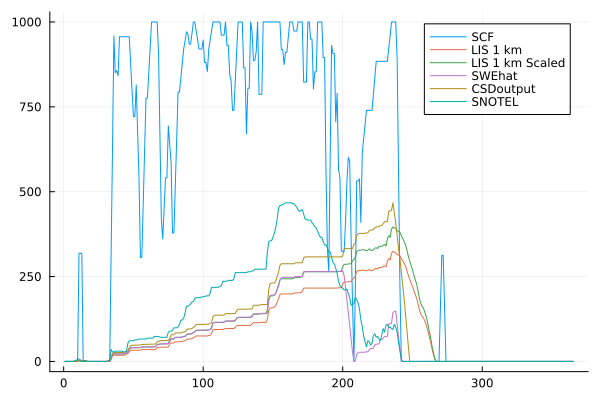

In [5]:
DataDir = "/Users/jldechow/Documents/GitHub/verse/Testing/RGV_Pix";
exp_dir = "/Users/jldechow/Documents/GitHub/verse/Testing/RGV_Pix/";
i = 1
j = 1
logDir = "/Users/jldechow/Documents/GitHub/verse/Testing/logs/"

WRFSWE=readdlm(DataDir * "/WRFSWE.txt"); #[m]
WRFP=readdlm(DataDir * "/WRFP.txt"); #[m]
WRFG=readdlm(DataDir * "/WRFG.txt");
MSCF=readdlm(DataDir * "/SCF.txt");
AirT=readdlm(DataDir * "/AirT.txt");
psVal = 1.2229;
#psVal = 2
WRFP = WRFP./1000;
WRFSWE  = WRFSWE./1000;
AirT = AirT./100;

blender(1, 1, WRFSWE, WRFP, WRFG, MSCF, AirT, psVal, logDir, exp_dir)
# Test resample SWE with 1% scale factor per day
# Clear and reload WRFSWE to make sure snow off date is correctly calculated

SWEhat = readdlm(DataDir * "/SWE.txt");     # read entire table (space-separated)           # extract first column
SCFhat = readdlm(DataDir * "/SCFhat.txt");

using Plots
# reload WRFSWE to make sure it isn't the changed version
t = 1:365
SNOTEL = readdlm(DataDir * "/RGV_mm.txt"); #[mm]
WRFSWE=readdlm(DataDir * "/WRFSWE.txt"); #[m]
CSDSWE=readdlm(DataDir * "/CSDSWE.txt"); #[m]
WRFSWE_ps = WRFSWE*psVal;
sweHatPlot = SWEhat.*1000;
csdPlot = CSDSWE.*1000;
mSCFPlot = SCFhat.*1000;
plot(t,mSCFPlot,label="SCF")
plot!(t,WRFSWE,label="LIS 1 km")
plot!(t,WRFSWE_ps,label="LIS 1 km Scaled")
plot!(t,sweHatPlot,label="SWEhat")
plot!(t,csdPlot,label="CSDoutput")
plot!(t,SNOTEL,label = "SNOTEL")

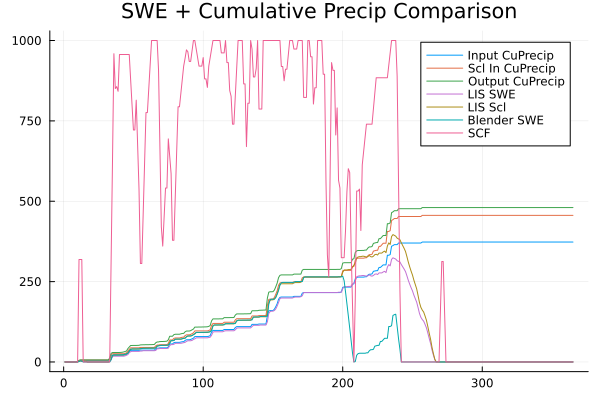

In [6]:
WRFP=readdlm(DataDir * "/WRFP.txt"); #[m]
Phat = readdlm(DataDir * "/Phat.txt");

holdWRFP = WRFP
holdWRFPscl =  WRFP.*psVal
holdPhat = Phat.*1000;

cumuWRFP = cumsum(holdWRFP[:])
cumuWRFPs = cumsum(holdWRFPscl[:])
cumuPhat = cumsum(holdPhat[:])

plot(t,cumuWRFP,label = "Input CuPrecip")
plot!(t,cumuWRFPs,label = "Scl In CuPrecip")
plot!(t,cumuPhat,label = "Output CuPrecip")
plot!(t,WRFSWE,label="LIS SWE")
plot!(t,WRFSWE_ps,label="LIS Scl")
plot!(t,sweHatPlot,label="Blender SWE")
plot!(t,mSCFPlot,label="SCF")
plot!(title = "SWE + Cumulative Precip Comparison")